In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pandas as pd
df2 = pd.read_csv('LBMA-GOLD.csv',header=0,index_col=0,parse_dates = True)
df1 = pd.read_csv('BCHAIN-MKPRU.csv',header=0, index_col=0,parse_dates=True)
df = pd.concat([df1,df2],axis=1,join='inner')
df = (df - df.mean())/df.std()

In [2]:
overall_pearson_r = df.corr().iloc[0,1]
print(f"Pandas computed Pearson r: {overall_pearson_r}")
# 输出：使用 Pandas 计算皮尔逊相关结果的 r 值

Pandas computed Pearson r: 0.6494709842626691


In [3]:
r, p = stats.pearsonr(df.dropna()['Value'], df.dropna()['USD (PM)'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")
# 输出：使用 Scipy 计算皮尔逊相关结果的 r 值以及 p-value

Scipy computed Pearson r: 0.6494709842626692 and p-value: 2.9912767847117392e-151


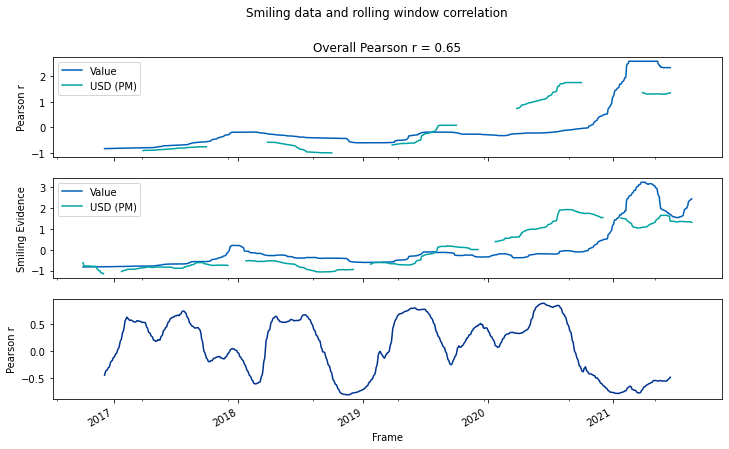

In [4]:
# 计算滑动窗口同步性
# 设置窗口宽度，以计算滑动窗口同步性
r_window_size = 120
# f,ax=plt.subplots(figsize=(14,3))
# plt.subplot(1,2,1)
f,ax=plt.subplots(3,1,figsize=(12,7),sharex=True)
df.rolling(window=r_window_size,center=True).median().plot(ax=ax[0],color=['#005FB8','#00A3A3'])
ax[0].set(xlabel='Time',ylabel='Pearson r')
ax[0].set(title=f"Overall Pearson r = {np.round(overall_pearson_r,2)}")
# 插入缺失值
df_interpolated = df.interpolate()
# 计算滑动窗口同步性
rolling_r = df_interpolated['Value'].rolling(window=r_window_size, center=True).corr(df_interpolated['USD (PM)'])
# f,ax=plt.subplots(2,1,figsize=(14,6),sharex=True)
df.rolling(window=30,center=True).median().plot(ax=ax[1],color=['#005FB8','#00A3A3'])
ax[1].set(xlabel='Frame',ylabel='Smiling Evidence')
rolling_r.plot(ax=ax[2],color='#00338D')
ax[2].set(xlabel='Frame',ylabel='Pearson r')
plt.suptitle("Smiling data and rolling window correlation")
plt.savefig('Pearson.png')
plt.show()

Text(0.5, 0.98, 'Smiling data and rolling window correlation')

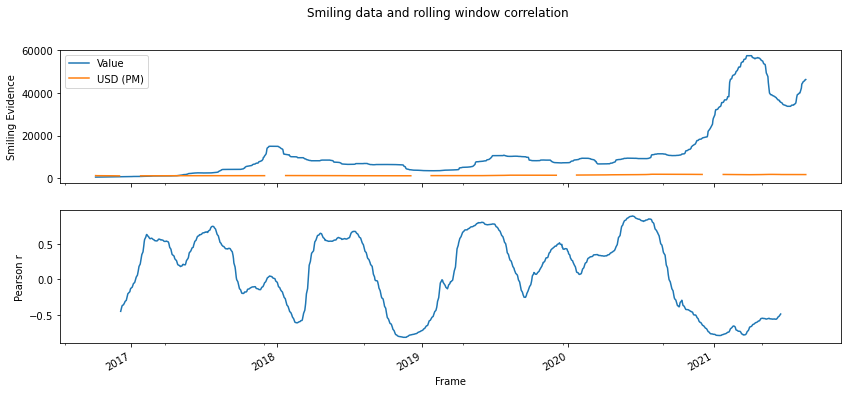

In [14]:
# 设置窗口宽度，以计算滑动窗口同步性
r_window_size = 120
# 插入缺失值
df_interpolated = df.interpolate()
# 计算滑动窗口同步性
rolling_r = df_interpolated['Value'].rolling(window=r_window_size, center=True).corr(df_interpolated['USD (PM)'])
f,ax=plt.subplots(2,1,figsize=(14,6),sharex=True)
df.rolling(window=30,center=True).median().plot(ax=ax[0])
ax[0].set(xlabel='Frame',ylabel='Smiling Evidence')
rolling_r.plot(ax=ax[1])
ax[1].set(xlabel='Frame',ylabel='Pearson r')
plt.suptitle("Smiling data and rolling window correlation")


C:\Users\TRACYT~1\AppData\Local\Temp/ipykernel_11288/3446692075.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(item-150) for item in ax.get_xticks()])


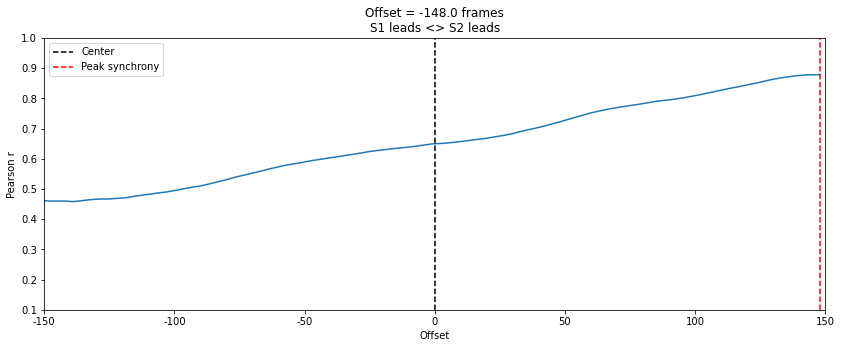

In [38]:

def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

d1 = df['Value']
d2 = df['USD (PM)']
seconds = 5
fps = 30
rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps-1),int(seconds*fps))]
offset = np.ceil(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,5))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads',ylim=[.1,1.0],xlim=[0,300], xlabel='Offset',ylabel='Pearson r')
ax.set_xticklabels([int(item-150) for item in ax.get_xticks()])
plt.legend()
plt.show()

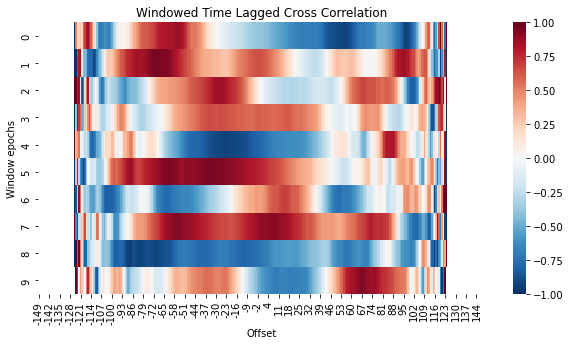

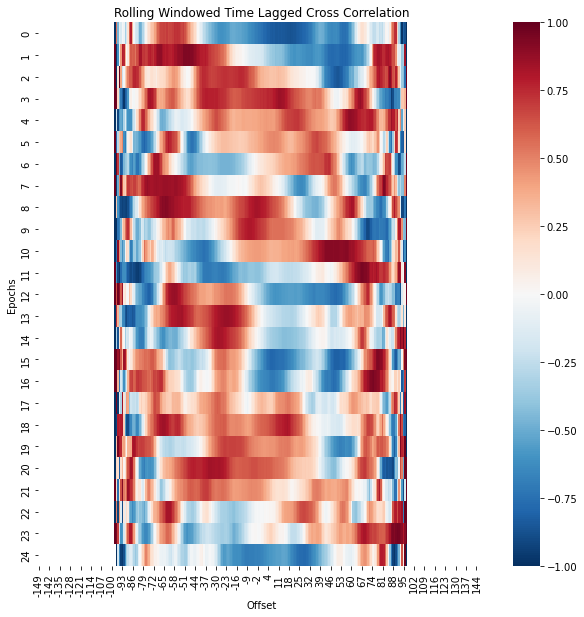

In [77]:
# 加窗的时间滞后互相关
seconds = 5
fps = 30
no_splits = 10
samples_per_split = df.shape[0]/no_splits
rss=[]
# df=df.reset_index()
for t in range(0, no_splits):
    d1 = df['Value'].loc[t*samples_per_split:(t+1)*samples_per_split]
    d2 = df['USD (PM)'].loc[t*samples_per_split:(t+1)*samples_per_split]
    rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps-1),int(seconds*fps))]
    rss.append(rs)
rss = pd.DataFrame(rss)
f,ax = plt.subplots(figsize=(10,5))
sns.heatmap(rss,cmap='RdBu_r',ax=ax)
ax.set(title=f'Windowed Time Lagged Cross Correlation',xlim=[0,300], xlabel='Offset',ylabel='Window epochs')
ax.set_xticklabels([int(item-150) for item in ax.get_xticks()]);

# 滑动窗口时间滞后互相关
seconds = 5
fps = 30
window_size = 100 #样本
t_start = 0
t_end = t_start + window_size
step_size = 20
rss=[]
while t_end < 600:
    d1 = df['Value'].iloc[t_start:t_end]
    d2 = df['USD (PM)'].iloc[t_start:t_end]
    rs = [crosscorr(d1,d2, lag, wrap=False) for lag in range(-int(seconds*fps-1),int(seconds*fps))]
    rss.append(rs)
    t_start = t_start + step_size
    t_end = t_end + step_size
rss = pd.DataFrame(rss)

f,ax = plt.subplots(figsize=(10,10))
sns.heatmap(rss,cmap='RdBu_r',ax=ax)
ax.set(title=f'Rolling Windowed Time Lagged Cross Correlation',xlim=[0,300], xlabel='Offset',ylabel='Epochs')
ax.set_xticklabels([int(item-150) for item in ax.get_xticks()])
plt.show()

In [16]:
from dtw import dtw,accelerated_dtw

d1 = df['Value'].interpolate()
d2 = df['USD (PM)'].interpolate()
df = pd.concat([d1,d2],axis=1,join='inner')
d1 = df['Value'].values
d2 = df['USD (PM)'].values

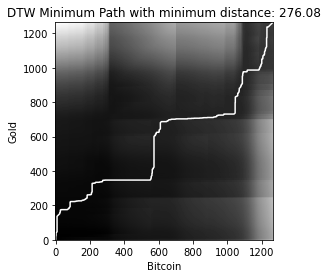

In [20]:
d, cost_matrix, acc_cost_matrix, path = accelerated_dtw(d1,d2, dist='euclidean')

plt.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.xlabel('Bitcoin')
plt.ylabel('Gold')
plt.title(f'DTW Minimum Path with minimum distance: {np.round(d,2)}')
plt.savefig('dtw.png')
plt.show()

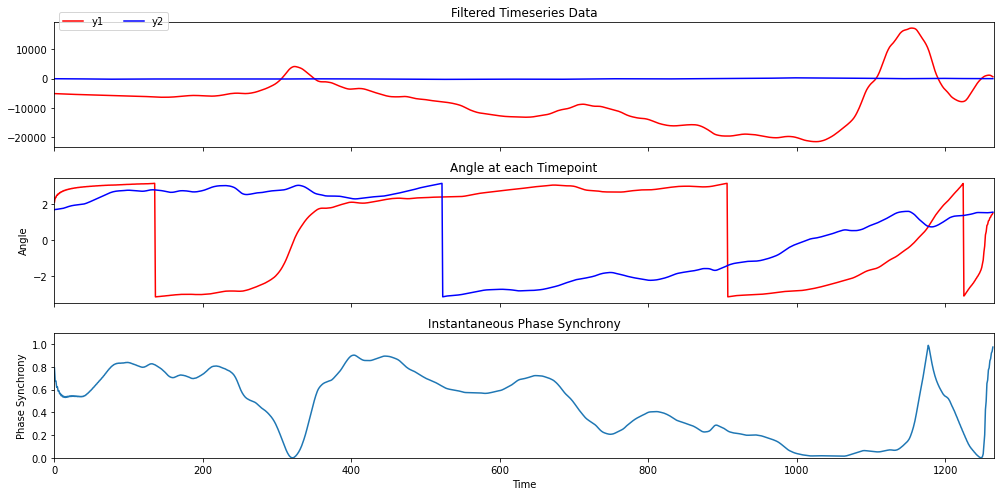

In [3]:

from scipy.signal import hilbert, butter, filtfilt
from scipy.fftpack import fft,fftfreq,rfft,irfft,ifft
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as stats
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

lowcut  = .01
highcut = .5
fs = 30.
order = 1
d1 = df['Value'].interpolate().values
d2 = df['USD (PM)'].interpolate().values
y1 = butter_bandpass_filter(d1,lowcut=lowcut,highcut=highcut,fs=fs,order=order)
y2 = butter_bandpass_filter(d2,lowcut=lowcut,highcut=highcut,fs=fs,order=order)

al1 = np.angle(hilbert(y1),deg=False)
al2 = np.angle(hilbert(y2),deg=False)
phase_synchrony = 1-np.sin(np.abs(al1-al2)/2)
N = len(al1)

# 绘制结果
f,ax = plt.subplots(3,1,figsize=(14,7),sharex=True)
ax[0].plot(y1,color='r',label='y1')
ax[0].plot(y2,color='b',label='y2')
ax[0].legend(bbox_to_anchor=(0., 1.02, 1., .102),ncol=2)
ax[0].set(xlim=[0,N], title='Filtered Timeseries Data')
ax[1].plot(al1,color='r')
ax[1].plot(al2,color='b')
ax[1].set(ylabel='Angle',title='Angle at each Timepoint',xlim=[0,N])
phase_synchrony = 1-np.sin(np.abs(al1-al2)/2)
ax[2].plot(phase_synchrony)
ax[2].set(ylim=[0,1.1],xlim=[0,N],title='Instantaneous Phase Synchrony',xlabel='Time',ylabel='Phase Synchrony')
plt.tight_layout()
plt.show()